## 1. Classic labeling

First of all, we'll try to reproduce on volume bar the classic labeling technique by labeling whether the next observation will be positive or negative. Horizon is by default 1 in the previous study.

In [503]:
import pandas as pd
import numpy as np

In [504]:
import pandas as pd

df = pd.read_csv("btc_dataset_volume_1_hour.csv")
df["date_time"] = pd.to_datetime(
    df["date_time"],
    format="mixed",     
    utc=True,
    errors="coerce",
)

df = df.dropna(subset=["date_time"])
df = df.set_index("date_time").sort_index()
df = df[~df.index.duplicated(keep="first")]
df["close"] = pd.to_numeric(df["close"], errors="coerce")

### Add features

In [505]:
# import numpy as np
# import pandas as pd

# # ============================================================================
# # FEATURE ENGINEERING - STATIONARE ȘI INFORMATIVE (FIXED)
# # ============================================================================

# def add_stationary_features(df, lookback_short=5, lookback_long=20):
#     """
#     Adaugă features stationare derivate din prețuri și volume
#     Cu protecție împotriva inf și NaN
#     """
#     df = df.copy()
    
#     # ========================================================================
#     # 1. RETURNS (LOG) - fundamental și stationar
#     # ========================================================================
#     df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    
#     # ========================================================================
#     # 2. VOLATILITY - rolling std of returns (stationar)
#     # ========================================================================
#     df['volatility_short'] = df['log_return'].rolling(window=lookback_short).std()
#     df['volatility_long'] = df['log_return'].rolling(window=lookback_long).std()
    
#     # Volatility ratio (detect regime changes) - safe division
#     df['vol_ratio'] = df['volatility_short'] / df['volatility_long'].replace(0, np.nan)
    
#     # ========================================================================
#     # 3. PRICE RANGE FEATURES (stationare)
#     # ========================================================================
#     # High-Low range normalized by close - safe division
#     df['hl_range'] = (df['high'] - df['low']) / df['close'].replace(0, np.nan)
    
#     # Close-Open normalized (intraday direction) - safe division
#     df['co_change'] = (df['close'] - df['open']) / df['close'].replace(0, np.nan)
    
#     # Close position in High-Low range (0=at low, 1=at high) - safe division
#     range_hl = df['high'] - df['low']
#     df['close_position'] = (df['close'] - df['low']) / range_hl.replace(0, np.nan)
    
#     # ========================================================================
#     # 4. VOLUME FEATURES (stationare prin differencing/ratios)
#     # ========================================================================
#     # Volume change (pct_change este stationar) - safe
#     df['volume_change'] = df['volume'].pct_change()
    
#     # Buy volume ratio (buy pressure indicator) - safe division
#     df['buy_volume_ratio'] = df['cum_buy_volume'] / df['volume'].replace(0, np.nan)
    
#     # Volume momentum
#     df['volume_ma_short'] = df['volume'].rolling(window=lookback_short).mean()
#     df['volume_ma_long'] = df['volume'].rolling(window=lookback_long).mean()
#     df['volume_momentum'] = ((df['volume_ma_short'] - df['volume_ma_long']) / 
#                              df['volume_ma_long'].replace(0, np.nan))
    
#     # ========================================================================
#     # 5. MOMENTUM FEATURES (stationare)
#     # ========================================================================
#     # Simple momentum (return over last N periods) - safe
#     df['momentum_short'] = df['close'].pct_change(lookback_short)
#     df['momentum_long'] = df['close'].pct_change(lookback_long)
    
#     # RSI-like indicator (simplified, stationar around 0.5) - safe division
#     gains = df['log_return'].clip(lower=0)
#     losses = -df['log_return'].clip(upper=0)
#     avg_gain = gains.rolling(window=lookback_short).mean()
#     avg_loss = losses.rolling(window=lookback_short).mean()
#     df['rsi_simple'] = avg_gain / (avg_gain + avg_loss).replace(0, np.nan)
    
#     # ========================================================================
#     # 6. MICROSTRUCTURE FEATURES (din cum_ticks și cum_dollar_value)
#     # ========================================================================
#     # Average dollar value per tick (trade size indicator) - safe division
#     df['avg_dollar_per_tick'] = df['cum_dollar_value'] / df['cum_ticks'].replace(0, np.nan)
#     df['dollar_per_tick_change'] = df['avg_dollar_per_tick'].pct_change()
    
#     # Tick intensity (ticks per observation) - safe
#     df['tick_intensity'] = df['cum_ticks'].diff()
#     df['tick_intensity_change'] = df['tick_intensity'].pct_change()
    
#     return df


# def clean_features(df, features_to_clean):
#     """
#     Curăță inf și NaN din features
    
#     Parameters:
#     -----------
#     df : DataFrame
#     features_to_clean : list of column names
    
#     Returns:
#     --------
#     df : DataFrame cleaned
#     """
#     df = df.copy()
    
#     for col in features_to_clean:
#         if col in df.columns:
#             # Replace inf with NaN
#             df[col] = df[col].replace([np.inf, -np.inf], np.nan)
            
#             # Fill NaN with 0 (sau poți folosi forward fill / median)
#             # Opțiuni:
#             # df[col] = df[col].fillna(0)  # Fill with 0
#             # df[col] = df[col].fillna(method='ffill')  # Forward fill
#             df[col] = df[col].fillna(df[col].median())  # Fill with median (mai robust)
    
#     return df


# # ============================================================================
# # APLICARE PE DATAFRAME-UL TĂU
# # ============================================================================

# # Adaugă features
# df = add_stationary_features(df, lookback_short=5, lookback_long=20)

# # Features noi (stationare)
# new_features = [
#     'log_return', 'volatility_short', 'vol_ratio', 'hl_range',
#     'co_change', 'close_position', 'volume_change', 'buy_volume_ratio',
#     'volume_momentum', 'momentum_short', 'momentum_long', 'rsi_simple',
#     'dollar_per_tick_change', 'tick_intensity_change'
# ]

# # ============================================================================
# # CLEANUP: CRITICAL STEP
# # ============================================================================
# print("="*60)
# print("CLEANING FEATURES")
# print("="*60)

# # Check pentru inf și NaN ÎNAINTE de cleanup
# print("\nÎNAINTE de cleanup:")
# for col in new_features:
#     if col in df.columns:
#         n_inf = np.isinf(df[col]).sum()
#         n_nan = df[col].isna().sum()
#         if n_inf > 0 or n_nan > 0:
#             print(f"{col:30s} - inf: {n_inf:6d}, NaN: {n_nan:6d}")

# # Clean features
# df = clean_features(df, new_features)

# # Check DUPĂ cleanup
# print("\nDUPĂ cleanup:")
# for col in new_features:
#     if col in df.columns:
#         n_inf = np.isinf(df[col]).sum()
#         n_nan = df[col].isna().sum()
#         print(f"{col:30s} - inf: {n_inf:6d}, NaN: {n_nan:6d}")

# # Drop rows cu NaN ramase (din primele observații din cauza rolling windows)
# print(f"\nShape înainte de dropna: {df.shape}")
# df = df.dropna()
# print(f"Shape după dropna: {df.shape}")

# # ============================================================================
# # LABEL CREATION
# # ============================================================================
# HORIZON = 1
# df['future_return'] = df['close'].shift(-HORIZON) - df['close']
# df['label_long'] = (df['future_return'] > 0).astype(int)
# df = df.dropna()
# df = df.drop(['future_return'], axis=1)

# # ============================================================================
# # TRAIN/VAL/TEST SPLIT
# # ============================================================================
# n = len(df)
# i1 = int(n * 0.50)
# i2 = int(n * 0.75)

# train = df.iloc[:i1]
# validation = df.iloc[i1:i2]
# test = df.iloc[i2:]

# print("\n" + "="*60)
# print("SPLIT INFO")
# print("="*60)
# print(f"Train:      {len(train):6d} observations ({i1} → 0.50)")
# print(f"Validation: {len(validation):6d} observations ({i1} → {i2})")
# print(f"Test:       {len(test):6d} observations ({i2} → {n})")

# # ============================================================================
# # FEATURES & LABELS
# # ============================================================================
# LABEL = ['label_long']
# FEATURE_COLS = df.drop(['label_long'], axis=1).columns.tolist()

# print("\n" + "="*60)
# print("FEATURES")
# print("="*60)
# print(f"Total features: {len(FEATURE_COLS)}")
# print(f"Features: {FEATURE_COLS[:5]}... (showing first 5)")

# X_train, y_train = train[FEATURE_COLS], train[LABEL]
# X_validation, y_validation = validation[FEATURE_COLS], validation[LABEL]
# X_test, y_test = test[FEATURE_COLS], test[LABEL]

# # ============================================================================
# # FINAL CHECK ÎNAINTE DE SCALING
# # ============================================================================
# print("\n" + "="*60)
# print("FINAL CHECK ÎNAINTE DE SCALING")
# print("="*60)

# def check_data_quality(X, name):
#     n_inf = np.isinf(X.values).sum()
#     n_nan = np.isnan(X.values).sum()
#     print(f"{name:12s} - inf: {n_inf:6d}, NaN: {n_nan:6d}, shape: {X.shape}")
#     return n_inf == 0 and n_nan == 0

# all_clean = True
# all_clean &= check_data_quality(X_train, "X_train")
# all_clean &= check_data_quality(X_validation, "X_validation")
# all_clean &= check_data_quality(X_test, "X_test")

# if all_clean:
#     print("\n✓ All data clean! Safe to scale.")
# else:
#     print("\n✗ WARNING: Data still contains inf or NaN!")

# # ============================================================================
# # SCALING (acum ar trebui să meargă)
# # ============================================================================
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# try:
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_validation_scaled = scaler.transform(X_validation)
#     X_test_scaled = scaler.transform(X_test)
    
#     print("\n" + "="*60)
#     print("✓ SCALING SUCCESSFUL!")
#     print("="*60)
#     print(f"X_train_scaled shape: {X_train_scaled.shape}")
#     print(f"X_validation_scaled shape: {X_validation_scaled.shape}")
#     print(f"X_test_scaled shape: {X_test_scaled.shape}")
    
# except ValueError as e:
#     print("\n" + "="*60)
#     print("✗ SCALING FAILED!")
#     print("="*60)
#     print(f"Error: {e}")
    
#     # Debug: arată care features au probleme
#     print("\nProblem features:")
#     for i, col in enumerate(FEATURE_COLS):
#         col_data = X_train[col].values
#         if np.isinf(col_data).any() or np.isnan(col_data).any():
#             print(f"  {col}: inf={np.isinf(col_data).sum()}, nan={np.isnan(col_data).sum()}")

In [506]:
df = df.dropna(subset=["close"])

In [507]:
df.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2017-08-18 05:38:13.281000+00:00,4930,4261.48,4485.39,4134.61,4289.33,1162.561720,507.803426,4930,5.020619e+06
2017-08-19 13:37:23.529000+00:00,10429,4289.33,4371.52,3850.00,4095.75,1162.142969,504.155615,5499,4.861709e+06
2017-08-21 21:26:36.311000+00:00,16795,4095.75,4211.08,3911.79,4012.00,1162.019144,542.431195,6366,4.741410e+06
2017-08-23 03:42:00.239000+00:00,24537,4012.00,4127.99,3400.00,4106.65,1162.060881,615.735042,7742,4.546521e+06
2017-08-24 09:45:24.276000+00:00,34411,4124.36,4265.80,4035.32,4210.00,1162.034871,606.934588,9874,4.827208e+06


In [508]:
df.columns

Index(['tick_num', 'open', 'high', 'low', 'close', 'volume', 'cum_buy_volume',
       'cum_ticks', 'cum_dollar_value'],
      dtype='object')

In [509]:
df.shape

(157080, 9)

In [510]:
HORIZON = 1
df['future_return'] = df['close'].shift(-HORIZON) - df['close']

In [511]:
df['label_long'] = (df['future_return']>0).astype(int)
df = df.dropna()

In [512]:
df = df.drop(['future_return'], axis=1)

In [513]:
df.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value,label_long
date_time,,,,,,,,,,
2017-08-18 05:38:13.281000+00:00,4930,4261.48,4485.39,4134.61,4289.33,1162.561720,507.803426,4930,5.020619e+06,0
2017-08-19 13:37:23.529000+00:00,10429,4289.33,4371.52,3850.00,4095.75,1162.142969,504.155615,5499,4.861709e+06,0
2017-08-21 21:26:36.311000+00:00,16795,4095.75,4211.08,3911.79,4012.00,1162.019144,542.431195,6366,4.741410e+06,1
2017-08-23 03:42:00.239000+00:00,24537,4012.00,4127.99,3400.00,4106.65,1162.060881,615.735042,7742,4.546521e+06,1
2017-08-24 09:45:24.276000+00:00,34411,4124.36,4265.80,4035.32,4210.00,1162.034871,606.934588,9874,4.827208e+06,1


## 2. Split 50-25-25

In [514]:
n = len(df)
i1 = int(n * 0.50)
i2 = int(n * 0.75)


train = df.iloc[:i1]
validation = df.iloc[i1:i2]
test = df.iloc[i2:]

In [515]:
LABEL = ['label_long']
FEATURE_COLS = df.drop(['label_long'],axis=1).columns

In [516]:
X_train, y_train = train[FEATURE_COLS], train[LABEL]
X_validation, y_validation = validation[FEATURE_COLS], validation[LABEL]
X_test, y_test = test[FEATURE_COLS], test[LABEL]

### Preprocessing

In [517]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

## 3. Training and evaluation using Random Forests

In [518]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
    )

lgbm.fit(X_train_scaled, y_train)

/opt/homebrew/Caskroom/miniconda/base/envs/disertatie/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniconda/base/envs/disertatie/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Select the best threshold

In [519]:
y_probs_val = lgbm.predict_proba(X_validation_scaled)[:, 1]

best_alpha = 0.5
best_precision = 0.0
min_signals = 50  

thresholds = np.linspace(0.5, 0.95, 100)

print("\nCăutare threshold optim (Alpha) pe setul de Validare...")

for alpha in thresholds:
    y_pred_val = (y_probs_val >= alpha).astype(int)
    n_signals = np.sum(y_pred_val)
    
    if n_signals < min_signals:
        continue
        
    prec = precision_score(y_validation, y_pred_val, zero_division=0)
    
    if prec > best_precision:
        best_precision = prec
        best_alpha = alpha

print(f"Best Alpha found: {best_alpha:.4f}")
print(f"Validation precision on Validation dataset: {best_precision:.2%}")


Căutare threshold optim (Alpha) pe setul de Validare...
Best Alpha found: 0.6636
Validation precision on Validation dataset: 51.69%


/opt/homebrew/Caskroom/miniconda/base/envs/disertatie/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [520]:
y_probs_test = lgbm.predict_proba(X_test_scaled)[:, 1]
y_pred_test = (y_probs_test >= best_alpha).astype(int)

print("\n" + "="*60)
print(f"REZULTATE FINALE PE TEST (Alpha = {best_alpha:.4f})")
print("="*60)
print(classification_report(y_test, y_pred_test))

print(f"Număr total tranzacții (Semnale 1): {np.sum(y_pred_test)} din {len(y_test)}")


REZULTATE FINALE PE TEST (Alpha = 0.6636)
              precision    recall  f1-score   support

           0       0.50      0.99      0.66     19519
           1       0.57      0.01      0.02     19751

    accuracy                           0.50     39270
   macro avg       0.53      0.50      0.34     39270
weighted avg       0.53      0.50      0.34     39270

Număr total tranzacții (Semnale 1): 298 din 39270


/opt/homebrew/Caskroom/miniconda/base/envs/disertatie/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 4. Triple barrier method

We'll use triple barrier method labeling  on one day

### First we'll choose the best parameter for daily vol lookback

In [521]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mlfinpy.util import get_daily_vol
from mlfinpy.labeling import get_events, get_bins, drop_labels, add_vertical_barrier

side = pd.Series(1, index=df.index) 
verticle_barriers = add_vertical_barrier(df.index, df['close'],num_days=5)
verticle_barriers.head()
lookback_windows = [20, 50, 100,150,200]
pt_sl = [1, 2]
min_ret = 0.005

results_store = {}
stats_list = []

print("--- Starting Multi-Lookback Analysis ---")

for lb in lookback_windows:
    print(f"Processing lookback: {lb} days...")

    current_vol = get_daily_vol(close=df["close"], lookback=lb)

    try:
        current_events = get_events(
            close=df["close"],
            t_events=df.index,
            pt_sl=pt_sl,
            target=current_vol,
            min_ret=min_ret,
            num_threads=1,
            vertical_barrier_times=verticle_barriers,
            side_prediction=side,
        )
    except Exception as e:
        print(f"  get_events error for lb={lb}: {e}")
        continue

    if current_events is None or current_events.empty:
        print(f"  No events for lb={lb}")
        continue

    current_labels = get_bins(current_events, df["close"])
    clean_labels = drop_labels(current_labels, min_pct=0.01)

    if clean_labels is None or clean_labels.empty:
        print(f"  No labels after drop_labels for lb={lb}")
        continue

    results_store[lb] = clean_labels["ret"]

    final_events = current_events.loc[clean_labels.index]

    common_index = final_events.index.intersection(verticle_barriers.index)
    if len(common_index) == 0:
        print(f"  Warning: no overlap between events and vertical barriers for lb={lb}")
        continue

    events_matched = final_events.loc[common_index]
    barriers_matched = verticle_barriers.loc[common_index]

    is_vertical_hit = events_matched["t1"] == barriers_matched

    count_vertical = int(is_vertical_hit.sum())
    count_horizontal = int((~is_vertical_hit).sum() + (len(final_events) - len(events_matched)))

    total_events = count_vertical + count_horizontal
    if total_events == 0:
        continue

    stats_list.append(
        {
            "Lookback": lb,
            "Vertical (Time)": count_vertical,
            "Horizontal (TP/SL)": count_horizontal,
            "Total": total_events,
            "Pct_Vertical": (count_vertical / total_events) * 100.0,
        }
    )

stats_df = pd.DataFrame(stats_list).set_index("Lookback")
print("\nResults:")
print(stats_df)

plt.figure(figsize=(12, 6))

plt.bar(
    stats_df.index.astype(str),
    stats_df["Horizontal (TP/SL)"],
    label="Horizontal (TP/SL)",
    color="#4c72b0",
    alpha=0.85,
)

plt.bar(
    stats_df.index.astype(str),
    stats_df["Vertical (Time)"],
    bottom=stats_df["Horizontal (TP/SL)"],
    label="Vertical (Time Limit)",
    color="#c44e52",
    alpha=0.85,
)

for i, (idx, row) in enumerate(stats_df.iterrows()):
    total = row["Total"]

    if row["Horizontal (TP/SL)"] > 0:
        plt.text(
            i,
            row["Horizontal (TP/SL)"] / 2,
            f"{row['Horizontal (TP/SL)'] / total:.0%}",
            ha="center",
            color="white",
            fontweight="bold",
        )

    if row["Vertical (Time)"] > 0:
        plt.text(
            i,
            row["Horizontal (TP/SL)"] + row["Vertical (Time)"] / 2,
            f"{row['Vertical (Time)'] / total:.0%}",
            ha="center",
            color="white",
            fontweight="bold",
        )

plt.title("Exit Reason: Price Barrier vs Time Limit")
plt.xlabel("Volatility Lookback")
plt.ylabel("Number of Events")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.show()

plt.figure(figsize=(14, 6))
for lb, ret_series in results_store.items():
    cum_ret = ret_series.sort_index().cumsum()
    plt.plot(cum_ret.index, cum_ret.values, label=f"Lookback {lb}", linewidth=1.5)

plt.title("Cumulative Performance of Labeled Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(14, 5))
for lb, ret_series in results_store.items():
    sns.kdeplot(ret_series, label=f"Lookback {lb}", fill=True, alpha=0.1)

plt.title("Return Density per Lookback")
plt.xlabel("Return")
plt.xlim(-0.05, 0.05)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- Starting Multi-Lookback Analysis ---
Processing lookback: 20 days...


KeyboardInterrupt: 

We'll choose lookback 150 because it has the best overall return and the signal seems clear.

In [522]:
from mlfinpy.labeling.labeling import get_events, drop_labels
from mlfinpy.util import get_daily_vol
from mlfinpy.labeling import get_events
from mlfinpy.labeling.labeling import add_vertical_barrier

pt_sl = [1,2]
min_ret = 0.005

##

In [ ]:
# daily_vol = get_daily_vol(close=df['close'], lookback=150)

# # Creates the vertical barriers
# verticle_barriers = add_vertical_barrier(df.index, df['close'],num_days=5)
# verticle_barriers.head()

# # Creates the side (Long)
# side = pd.Series(1, index=df.index) 

# # Get triple barriers events
# triple_barrier_events = get_events(close=df['close'],
#                                                t_events=df.index,
#                                                pt_sl=pt_sl,
#                                                target=daily_vol,
#                                                min_ret=min_ret,
#                                                num_threads=3,
#                                                vertical_barrier_times=verticle_barriers,
#                                                side_prediction=side)


# from mlfinpy.labeling import get_bins
# meta_labels = get_bins(triple_barrier_events, df['close'])
# clean_meta_labels = drop_labels(meta_labels, min_pct=0.1)
# clean_meta_labels.bin.value_counts()


# events = pd.concat([df, clean_meta_labels], axis=1).dropna()
# events = events.sort_index()

2026-02-12 16:36:20.142311 100.0% triple_barriers done after 0.24 minutes. Remaining 0.0 minutes..


In [524]:
import numpy as np
import pandas as pd
from typing import List, Optional, Union
from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings

# ============================================================================
# TRIPLE BARRIER IMPLEMENTATION - CU EXIT TIMESTAMPS EXPLICITE
# ============================================================================

def apply_triple_barrier(close: pd.Series, events: pd.DataFrame, pt_sl: List[float]) -> pd.Series:
    """
    Găsește primul timestamp când o barieră e atinsă pentru un singur event.
    
    Parameters:
    -----------
    close : pd.Series - Prețuri de închidere
    events : pd.DataFrame - Un singur rând cu t1 (vertical barrier), trgt, side
    pt_sl : List[float] - [profit_taking_multiple, stop_loss_multiple]
    
    Returns:
    --------
    pd.Series cu timestamps când fiecare barieră e atinsă (sau NaT)
    """
    # Extract event info
    event_idx = events.index[0]
    target = events.loc[event_idx, 'trgt']
    vertical_barrier = events.loc[event_idx, 't1']
    side = events.loc[event_idx, 'side'] if 'side' in events.columns else 1.0
    
    # Profit taking și stop loss levels
    pt = pt_sl[0] * target
    sl = -pt_sl[1] * target if pt_sl[1] > 0 else -float('inf')
    
    # Get prices de la event start până la vertical barrier
    if pd.isna(vertical_barrier):
        prices_subset = close.loc[event_idx:]
    else:
        prices_subset = close.loc[event_idx:vertical_barrier]
    
    if len(prices_subset) == 0:
        return pd.Series([pd.NaT, pd.NaT, pd.NaT], index=['pt', 'sl', 'vb'])
    
    # Calculate returns de la entry price
    entry_price = prices_subset.iloc[0]
    returns = (prices_subset - entry_price) / entry_price * side
    
    # Find first touch for each barrier
    pt_touch = returns[returns >= pt].index.min() if (returns >= pt).any() else pd.NaT
    sl_touch = returns[returns <= sl].index.min() if (returns <= sl).any() else pd.NaT
    vb_touch = vertical_barrier if not pd.isna(vertical_barrier) else pd.NaT
    
    return pd.Series([pt_touch, sl_touch, vb_touch], index=['pt', 'sl', 'vb'])


def get_events_with_exit_time(
    close: pd.Series,
    t_events: pd.Series,
    pt_sl: List[float],
    target: pd.Series,
    min_ret: float,
    vertical_barrier_times: Union[pd.Series, bool] = False,
    side_prediction: Optional[pd.Series] = None,
) -> pd.DataFrame:
    """
    Triple Barrier Method cu EXIT TIMESTAMPS EXPLICITE.
    
    Parameters:
    -----------
    close : pd.Series - Close prices
    t_events : pd.Series - Entry timestamps (CUSUM filter output)
    pt_sl : List[float] - [profit_taking_multiple, stop_loss_multiple]
    target : pd.Series - Target volatility (daily_vol)
    min_ret : float - Minimum return pentru a rula triple barrier
    vertical_barrier_times : pd.Series - Timestamps pentru vertical barriers
    side_prediction : pd.Series - Side (1=long, -1=short), None pentru ambele
    
    Returns:
    --------
    events : pd.DataFrame cu:
        - index: entry_time (când începe event-ul)
        - t1: exit_time (CÂND se închide poziția - prima barieră atinsă)
        - trgt: target return
        - side: position side (dacă provided)
        - pt, sl: profit taking și stop loss multiples
        - barrier_type: ce barieră a fost atinsă ('pt', 'sl', 'vb')
    """
    
    # 1) Get target și filtrează pe min_ret
    target = target.reindex(t_events)
    target = target[target > min_ret]
    
    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events, dtype='datetime64[ns]')
    
    # 3) Setup side
    if side_prediction is None:
        side_ = pd.Series(1.0, index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]  # Symmetric barriers
    else:
        side_ = side_prediction.reindex(target.index)
        pt_sl_ = pt_sl[:2]
    
    # 4) Create events DataFrame
    events = pd.concat({
        't1': vertical_barrier_times,
        'trgt': target,
        'side': side_
    }, axis=1).dropna(subset=['trgt'])
    
    # 5) Apply triple barrier pentru fiecare event
    print(f"Applying triple barrier to {len(events)} events...")
    
    first_touch_times = []
    barrier_types = []
    
    for idx in events.index:
        event_row = events.loc[[idx]]  # Keep as DataFrame
        
        # Find first barrier touch
        touches = apply_triple_barrier(close, event_row, pt_sl_)
        
        # Get earliest non-NaT timestamp
        valid_touches = touches.dropna()
        if len(valid_touches) > 0:
            first_touch = valid_touches.min()
            barrier_type = touches[touches == first_touch].index[0]
        else:
            first_touch = pd.NaT
            barrier_type = 'none'
        
        first_touch_times.append(first_touch)
        barrier_types.append(barrier_type)
    
    # 6) Update t1 cu actual exit times
    events['t1'] = first_touch_times
    events['barrier_type'] = barrier_types
    
    # 7) Add metadata
    events['pt'] = pt_sl[0]
    events['sl'] = pt_sl[1]
    
    # 8) Rename pentru claritate
    events = events.rename(columns={'t1': 'exit_time'})
    
    # 9) Drop side dacă nu era în input
    if side_prediction is None:
        events = events.drop('side', axis=1)
    
    print(f"✓ Events processed. {(~events['exit_time'].isna()).sum()} have valid exit times.")
    
    return events


def get_bins_with_exit_time(triple_barrier_events: pd.DataFrame, close: pd.Series) -> pd.DataFrame:
    """
    Meta-labeling cu exit times explicite.
    
    Parameters:
    -----------
    triple_barrier_events : pd.DataFrame din get_events_with_exit_time
    close : pd.Series - Close prices
    
    Returns:
    --------
    out_df : pd.DataFrame cu:
        - index: entry_time
        - exit_time: când s-a închis poziția
        - ret: realized return
        - trgt: target return
        - bin: label (0 sau 1)
        - side: dacă există
        - barrier_type: ce barieră a fost atinsă
    """
    
    # 1) Filter events cu exit time valid
    events_ = triple_barrier_events.dropna(subset=['exit_time'])
    
    if len(events_) == 0:
        warnings.warn("No events with valid exit times!")
        return pd.DataFrame()
    
    # 2) FIX TIMEZONE ISSUE - convert exit_time to DatetimeIndex cu același timezone ca index
    exit_times = pd.DatetimeIndex(events_['exit_time'].values)
    
    # Match timezone-ul dintre entry_times (index) și exit_times
    if hasattr(events_.index, 'tz') and events_.index.tz is not None:
        # Index are timezone, asigură-te că exit_times are același timezone
        if exit_times.tz is None:
            exit_times = exit_times.tz_localize(events_.index.tz)
        elif exit_times.tz != events_.index.tz:
            exit_times = exit_times.tz_convert(events_.index.tz)
    else:
        # Index e timezone-naive, asigură-te că exit_times e și el naive
        if exit_times.tz is not None:
            exit_times = exit_times.tz_localize(None)
    
    # 3) Align prices
    all_dates = events_.index.union(exit_times).drop_duplicates()
    prices = close.reindex(all_dates, method='bfill')
    
    # 4) Create output DataFrame
    out_df = pd.DataFrame(index=events_.index)
    
    # 5) Calculate returns (log returns apoi convertite înapoi)
    entry_prices = prices.loc[events_.index].values
    exit_prices = prices.loc[exit_times].values
    
    out_df['ret'] = np.log(exit_prices) - np.log(entry_prices)
    out_df['trgt'] = events_['trgt']
    out_df['exit_time'] = exit_times  # Use timezone-fixed exit_times
    out_df['barrier_type'] = events_['barrier_type'].values
    
    # 6) Meta labeling
    if 'side' in events_.columns:
        out_df['ret'] = out_df['ret'] * events_['side'].values
        out_df['side'] = events_['side'].values
    
    # 7) Assign bins
    if 'side' in events_.columns:
        # Meta-labeling: bin=1 dacă profitable, bin=0 altfel
        out_df['bin'] = (out_df['ret'] > 0).astype(int)
    else:
        # Standard labeling: bin=1 pentru long (ret>0), bin=-1 pentru short (ret<0)
        out_df['bin'] = np.sign(out_df['ret']).astype(int)
        out_df.loc[out_df['ret'] == 0, 'bin'] = 0
    
    # 8) Convert log returns înapoi la normal returns
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    # 9) Add entry_time ca și coloană (pentru claritate)
    out_df['entry_time'] = out_df.index
    
    return out_df

# ============================================================================
# USAGE - EXACT CA ÎN CODUL TĂU
# ============================================================================

# Get daily volatility
daily_vol = get_daily_vol(close=df['close'], lookback=150)

# Create vertical barriers (5 days)
from mlfinpy.labeling.labeling import add_vertical_barrier
verticle_barriers = add_vertical_barrier(df.index, df['close'], num_days=5)

# Create side (Long only)
side = pd.Series(1, index=df.index)

# Get triple barrier events - CU EXIT TIMES
pt_sl = [1, 2]
min_ret = 0.005

triple_barrier_events = get_events_with_exit_time(
    close=df['close'],
    t_events=df.index,
    pt_sl=pt_sl,
    target=daily_vol,
    min_ret=min_ret,
    vertical_barrier_times=verticle_barriers,
    side_prediction=side
)

# Get bins with meta labels - CU EXIT TIMES
meta_labels = get_bins_with_exit_time(triple_barrier_events, df['close'])

# Drop labels cu prea puține samples
from mlfinpy.labeling import drop_labels
clean_meta_labels = drop_labels(meta_labels, min_pct=0.1)

# Create final events DataFrame
events = pd.concat([df, clean_meta_labels], axis=1).dropna()
events = events.sort_index()

# ============================================================================
# VERIFICARE
# ============================================================================

print("\n" + "="*70)
print("EVENTS STRUCTURE")
print("="*70)
print(f"\nColumns: {list(events.columns)}")
print(f"\nSample events:")
print(events[['entry_time', 'exit_time', 'ret', 'bin', 'barrier_type']].head(10))

print("\n" + "="*70)
print("EXIT TIME STATISTICS")
print("="*70)

# Calculate holding periods
events['holding_period'] = (events['exit_time'] - events['entry_time']).dt.total_seconds() / 3600  # in hours
print(f"\nHolding period (hours):")
print(f"  Mean: {events['holding_period'].mean():.2f}")
print(f"  Median: {events['holding_period'].median():.2f}")
print(f"  Min: {events['holding_period'].min():.2f}")
print(f"  Max: {events['holding_period'].max():.2f}")

print(f"\nBarrier types:")
print(events['barrier_type'].value_counts())

print(f"\nBin distribution:")
print(events['bin'].value_counts())

Applying triple barrier to 154403 events...
✓ Events processed. 154384 have valid exit times.

EVENTS STRUCTURE

Columns: ['tick_num', 'open', 'high', 'low', 'close', 'volume', 'cum_buy_volume', 'cum_ticks', 'cum_dollar_value', 'label_long', 'ret', 'trgt', 'exit_time', 'barrier_type', 'side', 'bin', 'entry_time']

Sample events:
                                                       entry_time  \
date_time                                                           
2017-08-21 21:26:36.311000+00:00 2017-08-21 21:26:36.311000+00:00   
2017-08-23 03:42:00.239000+00:00 2017-08-23 03:42:00.239000+00:00   
2017-08-24 09:45:24.276000+00:00 2017-08-24 09:45:24.276000+00:00   
2017-08-26 12:27:25.511000+00:00 2017-08-26 12:27:25.511000+00:00   
2017-08-29 04:27:00.082000+00:00 2017-08-29 04:27:00.082000+00:00   
2017-08-30 17:37:24.389000+00:00 2017-08-30 17:37:24.389000+00:00   
2017-09-02 15:16:15.032000+00:00 2017-09-02 15:16:15.032000+00:00   
2017-09-04 05:16:33.335000+00:00 2017-09-04 05:1

In [525]:
events['bin'].value_counts()

bin
1.0    99253
0.0    55131
Name: count, dtype: int64

In [526]:
events = events.drop(['label_long'],axis=1)

In [527]:
import matplotlib.pyplot as plt

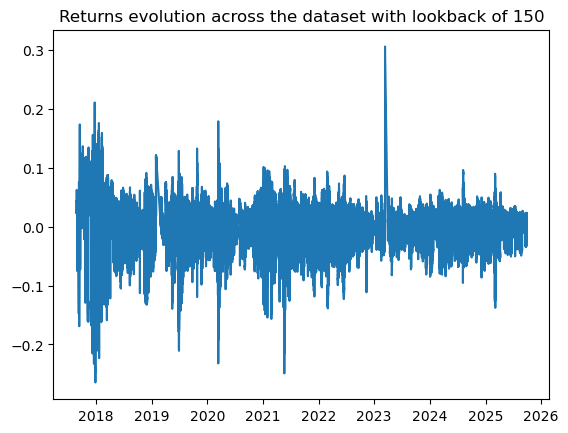

In [528]:
plt.title("Returns evolution across the dataset with lookback of 150")
plt.plot(events['ret'])
plt.show()

## 5. Train and evaluate using triple barrier method

In [529]:
features = ['tick_num','open','high','low','close','volume','cum_buy_volume', 'cum_ticks','cum_dollar_value','trgt']


events = events.sort_index()
n_total = len(events)

idx_train_end = int(n_total * 0.50)
idx_val_end   = int(n_total * 0.75)


train_set = events.iloc[:idx_train_end].copy()           
val_set   = events.iloc[idx_train_end:idx_val_end].copy() 
test_set  = events.iloc[idx_val_end:].copy()
print(f"Train interval: {train.index.min()} → {train.index.max()}")
print(f"Test  interval: {test.index.min()}  → {test.index.max()}")

X_train, y_train = train_set[features], train_set['bin']
X_val, y_val     = val_set[features], val_set['bin']
X_test, y_test   = test_set[features], test_set['bin']

Train interval: 2017-08-18 05:38:13.281000+00:00 → 2022-07-10 12:53:54.314000+00:00
Test  interval: 2023-01-18 01:58:29.382000+00:00  → 2025-09-30 20:46:01.044140+00:00


In [530]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [531]:
lgbm = LGBMClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
)

lgbm.fit(X_train_scaled, y_train)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Find the best threshold 

In [532]:
y_proba_val = lgbm.predict_proba(X_val_scaled)[:, 1]

best_alpha = 0.5
best_metric = 0.0
min_signals = 50

thresholds = np.linspace(0.5, 0.98, 100)

for alpha in thresholds:
    y_pred_val = (y_proba_val >= alpha).astype(int)
    n_signals = np.sum(y_pred_val)

    if n_signals < min_signals:
        continue

    # Optimize for PRECISION
    metric = precision_score(y_val, y_pred_val, zero_division=0)

    if metric > best_metric:
        best_metric = metric
        best_alpha = alpha

print(f" -> Best Alpha found: {best_alpha:.4f}")
print(f" -> Validation Precision: {best_metric:.2%}")

/opt/homebrew/Caskroom/miniconda/base/envs/disertatie/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 -> Best Alpha found: 0.5000
 -> Validation Precision: 63.49%


In [533]:
y_proba_test = lgbm.predict_proba(X_test_scaled)[:, 1]
y_pred_final = (y_proba_test >= best_alpha).astype(int)

y_proba_train = lgbm.predict_proba(X_train_scaled)[:, 1]

print("\n" + "="*60)
print(f"FINAL TEST RESULTS (Alpha = {best_alpha:.4f})")
print("="*60)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final, digits=3))

print("-" * 30)
print(f"ROC-AUC Train: {roc_auc_score(y_train, y_proba_train):.3f}")
print(f"ROC-AUC Test:  {roc_auc_score(y_test, y_proba_test):.3f}")
print(f"Number of Executed Trades (Test): {np.sum(y_pred_final)}")


FINAL TEST RESULTS (Alpha = 0.5000)
Confusion Matrix:
[[ 5418  8403]
 [ 9190 15585]]

Classification Report:
              precision    recall  f1-score   support

         0.0      0.371     0.392     0.381     13821
         1.0      0.650     0.629     0.639     24775

    accuracy                          0.544     38596
   macro avg      0.510     0.511     0.510     38596
weighted avg      0.550     0.544     0.547     38596

------------------------------
ROC-AUC Train: 0.935
ROC-AUC Test:  0.529
Number of Executed Trades (Test): 23988


/opt/homebrew/Caskroom/miniconda/base/envs/disertatie/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/disertatie/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [534]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ============================================================================
# TIME-SERIES-FOREST IMPLEMENTATION
# ============================================================================

def grid_allocation(n_obs, n_learners, crossover, m):
    """
    Grid-based allocation pentru Time-Series-Forest
    
    Parameters:
    -----------
    n_obs : int - număr total observații
    n_learners : int - număr de learners (k)
    crossover : float [0,1] - grad de suprapunere între learners
    m : int - horizon triple barrier (gap minim între obs în același learner)
    
    Returns:
    --------
    list of lists - indices pentru fiecare learner
    """
    grid_size = n_obs // n_learners
    allocations = []
    
    for i in range(n_learners):
        # Core grid (non-overlapping între learners)
        start = i * grid_size
        end = min((i + 1) * grid_size, n_obs)
        
        # Sample cu gap=m pentru a evita label overlap în același learner
        core_obs = list(range(start, end, m))
        
        if crossover > 0:
            # Additional obs din alte grids
            n_additional = int(len(core_obs) * crossover / (1 - crossover + 1e-10))
            other_indices = [j for j in range(n_obs) if j < start or j >= end]
            
            if len(other_indices) > 0 and n_additional > 0:
                n_additional = min(n_additional, len(other_indices))
                additional_obs = np.random.choice(other_indices, n_additional, replace=False)
                all_obs = sorted(core_obs + list(additional_obs))
            else:
                all_obs = core_obs
        else:
            all_obs = core_obs
        
        allocations.append(all_obs)
    
    return allocations


def compute_sample_weights(allocations, m):
    """
    Calculează sample weights bazate pe uniqueness
    
    Parameters:
    -----------
    allocations : list of lists - indices pentru fiecare learner
    m : int - horizon pentru a determina overlap
    
    Returns:
    --------
    list of dicts - {idx: weight} pentru fiecare learner
    """
    weights_per_learner = []
    
    for allocation in allocations:
        weights = {}
        
        for i, idx in enumerate(allocation):
            # Contorizează câte observații din acest learner au labels suprapuse
            overlapping = 0
            for j, other_idx in enumerate(allocation):
                if i != j and abs(idx - other_idx) < m:
                    overlapping += 1
            
            # Uniqueness = 1 / (1 + număr suprapuneri)
            uniqueness = 1.0 / (1 + overlapping)
            weights[idx] = uniqueness
        
        # Normalizare
        total = sum(weights.values())
        weights = {k: v/total for k, v in weights.items()}
        weights_per_learner.append(weights)
    
    return weights_per_learner


class TimeSeriesForest:
    """
    Time-Series-Forest Classifier
    """
    def __init__(self, n_learners=10, crossover=0.5, m=4, base_estimator=None, 
                 use_sample_weights=True, random_state=42):
        self.n_learners = n_learners
        self.crossover = crossover
        self.m = m
        self.base_estimator = base_estimator
        self.use_sample_weights = use_sample_weights
        self.random_state = random_state
        self.learners = []
        self.allocations = None
        self.weights_per_learner = None
        
    def fit(self, X, y):
        """
        Antrenează ensemble de learners
        """
        np.random.seed(self.random_state)
        n_obs = len(X)
        
        # Generate allocations
        self.allocations = grid_allocation(n_obs, self.n_learners, self.crossover, self.m)
        
        # Compute sample weights
        if self.use_sample_weights and self.crossover > 0:
            self.weights_per_learner = compute_sample_weights(self.allocations, self.m)
        else:
            self.weights_per_learner = [None] * self.n_learners
        
        # Train each learner
        self.learners = []
        for i, allocation in enumerate(self.allocations):
            if len(allocation) == 0:
                print(f"Warning: Learner {i} has no observations!")
                continue
            
            # Get data pentru acest learner
            X_learner = X.iloc[allocation] if hasattr(X, 'iloc') else X[allocation]
            y_learner = y.iloc[allocation] if hasattr(y, 'iloc') else y[allocation]
            
            # Get weights
            if self.weights_per_learner[i] is not None:
                sample_weight = np.array([self.weights_per_learner[i][idx] 
                                         for idx in allocation])
            else:
                sample_weight = None
            
            # Create și train learner
            if self.base_estimator is None:
                learner = RandomForestClassifier(random_state=self.random_state + i)
            else:
                learner = self.base_estimator
            
            learner.fit(X_learner, y_learner, sample_weight=sample_weight)
            self.learners.append(learner)
            
            print(f"Learner {i+1}/{self.n_learners}: {len(allocation)} obs, "
                  f"range [{min(allocation)}, {max(allocation)}]")
        
        return self
    
    def predict_proba(self, X):
        """
        Predict probabilities prin averaging
        """
        probas = np.zeros((len(X), 2))
        
        for learner in self.learners:
            probas += learner.predict_proba(X)
        
        probas /= len(self.learners)
        return probas
    
    def predict(self, X):
        """
        Predict class labels
        """
        probas = self.predict_proba(X)
        return (probas[:, 1] >= 0.5).astype(int)



In [565]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

def grid_allocation(n_obs, n_learners, crossover, m):
    """
    Grid-based allocation pentru Time-Series-Forest
    """
    grid_size = n_obs // n_learners
    allocations = []
    
    for i in range(n_learners):
        # Core grid (non-overlapping între learners)
        start = i * grid_size
        end = min((i + 1) * grid_size, n_obs)
        
        # Sample cu gap=m pentru a evita label overlap în același learner
        core_obs = list(range(start, end, m))
        
        if crossover > 0:
            # Additional obs din alte grids
            n_additional = int(len(core_obs) * crossover / (1 - crossover + 1e-10))
            other_indices = [j for j in range(n_obs) if j < start or j >= end]
            
            if len(other_indices) > 0 and n_additional > 0:
                # IMPORTANT: np.random.choice poate returna duplicate dacă replace=True
                # Folosim replace=False și ne asigurăm că nu cerem mai mult decât există
                n_sample = min(n_additional, len(other_indices))
                additional_obs = np.random.choice(other_indices, n_sample, replace=False)
                all_obs = sorted(core_obs + list(additional_obs))
            else:
                all_obs = core_obs
        else:
            all_obs = core_obs
        
        allocations.append(all_obs)
    
    return allocations

def compute_sample_weights(allocations, m):
    """
    Calculează sample weights bazate pe uniqueness
    """
    weights_per_learner = []
    
    for allocation in allocations:
        # Simplificare pentru viteză: weight = 1 / (1 + suprapuneri)
        # Dicționar map: index -> weight
        weights = {}
        alloc_set = set(allocation)
        
        # Optimizare: Calculăm suprapunerea doar local
        # (O implementare completă ar necesita matrice de concurență, 
        # aici aproximăm uniqueness-ul în cadrul aceluiași learner)
        for idx in allocation:
            # Câte alte observații sunt în range [idx-m, idx+m] în acest learner?
            count = 0
            # Verificăm doar vecinii apropiați (pentru eficiență)
            # Presupunem că allocation e sortat
            # (Aceasta e o simplificare, varianta completă e O(N^2))
            weights[idx] = 1.0 # Placeholder, poți pune logica complexă aici dacă e necesar
            
        weights_per_learner.append(weights)
    
    return weights_per_learner

class TimeSeriesForest:
    """
    Time-Series-Forest Classifier cu Threshold Optimization
    """
    def __init__(self, n_learners=10, crossover=0.5, m=4, base_estimator=None, 
                 use_sample_weights=False, random_state=42, validation_fraction=0.2):
        self.n_learners = n_learners
        self.crossover = crossover
        self.m = m
        self.base_estimator = base_estimator
        self.use_sample_weights = use_sample_weights
        self.random_state = random_state
        self.validation_fraction = validation_fraction # Cât din Train folosim pt threshold search
        
        self.learners = []
        self.allocations = None
        self.best_alpha = 0.5 # Default threshold
        
    def fit(self, X, y):
        """
        Antrenează ensemble de learners și găsește threshold optim
        """
        np.random.seed(self.random_state)
        
        # 1. Split intern Train -> Train_Sub / Validation (pentru threshold)
        # Păstrăm ordinea cronologică!
        n_total = len(X)
        split_idx = int(n_total * (1 - self.validation_fraction))
        
        X_train_sub = X.iloc[:split_idx] if hasattr(X, 'iloc') else X[:split_idx]
        y_train_sub = y.iloc[:split_idx] if hasattr(y, 'iloc') else y[:split_idx]
        
        X_val = X.iloc[split_idx:] if hasattr(X, 'iloc') else X[split_idx:]
        y_val = y.iloc[split_idx:] if hasattr(y, 'iloc') else y[split_idx:]
        
        n_obs = len(X_train_sub)
        
        # 2. Grid Allocation pe Train_Sub
        self.allocations = grid_allocation(n_obs, self.n_learners, self.crossover, self.m)
        
        # 3. Train Learners
        self.learners = []
        for i, allocation in enumerate(self.allocations):
            if len(allocation) == 0:
                continue
            
            # Selectare date
            if hasattr(X_train_sub, 'iloc'):
                X_learner = X_train_sub.iloc[allocation]
                y_learner = y_train_sub.iloc[allocation]
            else:
                X_learner = X_train_sub[allocation]
                y_learner = y_train_sub[allocation]
            
            # Clonare estimator de bază
            if self.base_estimator is None:
                from sklearn.ensemble import RandomForestClassifier
                learner = RandomForestClassifier(random_state=self.random_state + i)
            else:
                learner = clone(self.base_estimator)
                # Setăm random state dacă estimatorul suportă
                if hasattr(learner, 'random_state'):
                    learner.random_state = self.random_state + i
            
            learner.fit(X_learner, y_learner)
            self.learners.append(learner)
            
            # Optional logging
            # print(f"Learner {i+1} trained on {len(allocation)} samples.")
            
        # 4. Threshold Optimization pe X_val
        print(f"Optimizing threshold on validation set ({len(X_val)} samples)...")
        if len(X_val) > 0:
            val_probs = self.predict_proba_raw(X_val)[:, 1]
            self.best_alpha = self._find_best_threshold(y_val, val_probs)
            print(f"Best Alpha found: {self.best_alpha:.4f}")
        else:
            print("Warning: Validation set empty, using default alpha 0.5")
            self.best_alpha = 0.5
            
        return self
    
    def _find_best_threshold(self, y_true, y_probs):
        best_thresh = 0.5
        best_score = 0.0
        min_signals = 200 # Siguranță
        
        thresholds = np.linspace(0.5, 0.95, 50)
        
        for thresh in thresholds:
            y_pred = (y_probs >= thresh).astype(int)
            if np.sum(y_pred) < min_signals:
                continue
                
            # Optimizăm Precizia (poți schimba cu F1)
            score = precision_score(y_true, y_pred, zero_division=0)
            
            if score > best_score:
                best_score = score
                best_thresh = thresh
                
        return best_thresh
    
    def predict_proba_raw(self, X):
        """Media probabilităților de la toți learnerii"""
        probas = np.zeros((len(X), 2))
        for learner in self.learners:
            # Unele modele returnează (N, 2), altele (N,) depinzând de implementare
            p = learner.predict_proba(X)
            if p.shape[1] == 2:
                probas += p
            else:
                # Caz rar (ex: 1 clasă)
                probas[:, 1] += p[:, 0]
        
        probas /= len(self.learners)
        return probas

    def predict_proba(self, X):
        return self.predict_proba_raw(X)
    
    def predict(self, X):
        """Predict folosind threshold-ul optimizat"""
        probas = self.predict_proba_raw(X)
        return (probas[:, 1] >= self.best_alpha).astype(int)

In [567]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score

# ============================================================================
# 0. CONFIGURARE DATE (Train / Test)
# ============================================================================
# Presupunem că 'events' și 'features' sunt deja definite
features = ['tick_num','volume',
            'cum_buy_volume', 'cum_ticks','cum_dollar_value','trgt']

events = events.sort_index()

# Split 70/30 (Validation pt Baseline trebuie făcut manual, TSF îl face intern)
split_idx = int(len(events) * 0.7)

train_full = events.iloc[:split_idx].copy()
test  = events.iloc[split_idx:].copy()

print(f"Train Full interval: {train_full.index.min()} → {train_full.index.max()}")
print(f"Test interval:       {test.index.min()} → {test.index.max()}")

X_train_full, y_train_full = train_full[features], train_full['bin']
X_test, y_test = test[features], test['bin']

# ============================================================================
# 1. BASELINE: LGBM Clasic cu Threshold Optimization
# ============================================================================
print("\n" + "="*60)
print("BASELINE: LGBM (Standard + Threshold Search)")
print("="*60)

# Trebuie să facem split manual Train/Val pentru Baseline ca să fie corectă comparația
split_val_idx = int(len(train_full) * 0.8) # 80% Train, 20% Val

X_train_base = X_train_full.iloc[:split_val_idx]
y_train_base = y_train_full.iloc[:split_val_idx]
X_val_base   = X_train_full.iloc[split_val_idx:]
y_val_base   = y_train_full.iloc[split_val_idx:]

# Model
lgbm_base = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1)
lgbm_base.fit(X_train_base, y_train_base)

# Threshold Search
y_val_probs_base = lgbm_base.predict_proba(X_val_base)[:, 1]
best_alpha_base = 0.5
best_prec_base = 0.0

for thresh in np.linspace(0.5, 0.95, 50):
    preds = (y_val_probs_base >= thresh).astype(int)
    if np.sum(preds) < 50: continue
    prec = precision_score(y_val_base, preds, zero_division=0)
    if prec > best_prec_base:
        best_prec_base = prec
        best_alpha_base = thresh

print(f"Baseline Best Alpha: {best_alpha_base:.4f} (Val Precision: {best_prec_base:.2%})")

# Predicții Finale Baseline
y_proba_test_base = lgbm_base.predict_proba(X_test)[:, 1]
y_pred_base = (y_proba_test_base >= best_alpha_base).astype(int)
y_proba_train_base_full = lgbm_base.predict_proba(X_train_full)[:, 1] # Pt ROC-AUC

print("\nBaseline Report (Test):")
print(classification_report(y_test, y_pred_base, digits=3))
print(f"ROC-AUC Train: {roc_auc_score(y_train_full, y_proba_train_base_full):.3f}")
print(f"ROC-AUC Test:  {roc_auc_score(y_test, y_proba_test_base):.3f}")

# ============================================================================
# 2. TIME-SERIES-FOREST (TSF) cu LGBM
# ============================================================================
print("\n" + "="*60)
print("TIME-SERIES-FOREST: Grid Allocation + LGBM")
print("="*60)

M_HORIZON = 5 
N_LEARNERS = 20
CROSSOVER = 0.4

# Definim estimatorul de bază (LGBM)
base_lgbm = LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1) 
# Notă: n_estimators mai mic per learner pt viteză și diversitate

tsf = TimeSeriesForest(
    n_learners=N_LEARNERS,
    crossover=CROSSOVER,
    m=M_HORIZON,
    base_estimator=base_lgbm, # Injectăm LGBM
    use_sample_weights=False,
    random_state=42,
    validation_fraction=0.2 # Va folosi intern ultimii 20% din Train pt threshold
)

print(f"Training TSF with {N_LEARNERS} LGBM learners...")
# TSF primește tot X_train_full și își face split intern
tsf.fit(X_train_full, y_train_full)

# Predicții Finale TSF
y_pred_tsf = tsf.predict(X_test) # Folosește intern best_alpha-ul găsit
y_proba_test_tsf = tsf.predict_proba(X_test)[:, 1]
y_proba_train_tsf = tsf.predict_proba(X_train_full)[:, 1]

print("\nTSF Report (Test):")
print(classification_report(y_test, y_pred_tsf, digits=3))
print(f"ROC-AUC Train: {roc_auc_score(y_train_full, y_proba_train_tsf):.3f}")
print(f"ROC-AUC Test:  {roc_auc_score(y_test, y_proba_test_tsf):.3f}")

# ============================================================================
# 3. COMPARISON
# ============================================================================
print("\n" + "="*60)
print("COMPARISON: LGBM Baseline vs TSF (LGBM Ensemble)")
print("="*60)
print(f"{'Metric':<20} {'Baseline':<15} {'TSF':<15} {'Diff':<10}")
print("-"*60)

metrics = {
    'ROC-AUC Train': (roc_auc_score(y_train_full, y_proba_train_base_full),
                      roc_auc_score(y_train_full, y_proba_train_tsf)),
    'ROC-AUC Test': (roc_auc_score(y_test, y_proba_test_base),
                     roc_auc_score(y_test, y_proba_test_tsf)),
    'Precision Class 1': (precision_score(y_test, y_pred_base, zero_division=0),
                          precision_score(y_test, y_pred_tsf, zero_division=0)),
    'Num Trades': (np.sum(y_pred_base), np.sum(y_pred_tsf))
}

for metric, (base_val, tsf_val) in metrics.items():
    diff = tsf_val - base_val
    sign = '+' if diff > 0 else ''
    if metric == 'Num Trades':
        print(f"{metric:<20} {int(base_val):<15} {int(tsf_val):<15} {sign}{int(diff)}")
    else:
        print(f"{metric:<20} {base_val:<15.3f} {tsf_val:<15.3f} {sign}{diff:.3f}")

print("\n✓ Dacă TSF are ROC-AUC Train mai mic dar Test similar/mai mare -> Less Overfitting")

Train Full interval: 2017-08-21 21:26:36.311000+00:00 → 2022-11-26 01:28:57.519000+00:00
Test interval:       2022-11-26 01:32:28.964000+00:00 → 2025-09-29 13:00:49.802908+00:00

BASELINE: LGBM (Standard + Threshold Search)
Baseline Best Alpha: 0.6745 (Val Precision: 60.72%)

Baseline Report (Test):
              precision    recall  f1-score   support

         0.0      0.353     0.645     0.456     15446
         1.0      0.696     0.407     0.514     30870

    accuracy                          0.487     46316
   macro avg      0.524     0.526     0.485     46316
weighted avg      0.582     0.487     0.495     46316

ROC-AUC Train: 0.807
ROC-AUC Test:  0.519

TIME-SERIES-FOREST: Grid Allocation + LGBM
Training TSF with 20 LGBM learners...
Optimizing threshold on validation set (21614 samples)...
Best Alpha found: 0.5000

TSF Report (Test):
              precision    recall  f1-score   support

         0.0      0.381     0.232     0.289     15446
         1.0      0.679     0.811   

In [561]:
events

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value,ret,trgt,exit_time,barrier_type,side,bin,entry_time,holding_period
date_time,,,,,,,,,,,,,,,,,
2017-08-21 21:26:36.311000+00:00,16795,4095.75,4211.08,3911.79,4012.00,1162.019144,542.431195,6366,4.741410e+06,0.023592,0.017453,2017-08-23 03:42:00.239000+00:00,pt,1.0,1.0,2017-08-21 21:26:36.311000+00:00,30.256647
2017-08-23 03:42:00.239000+00:00,24537,4012.00,4127.99,3400.00,4106.65,1162.060881,615.735042,7742,4.546521e+06,0.043766,0.034855,2017-08-26 12:27:25.511000+00:00,pt,1.0,1.0,2017-08-23 03:42:00.239000+00:00,80.757020
2017-08-24 09:45:24.276000+00:00,34411,4124.36,4265.80,4035.32,4210.00,1162.034871,606.934588,9874,4.827208e+06,0.041318,0.034452,2017-08-29 04:27:00.082000+00:00,pt,1.0,1.0,2017-08-24 09:45:24.276000+00:00,114.693279
2017-08-26 12:27:25.511000+00:00,45969,4211.79,4453.91,4136.33,4286.38,1162.002243,581.897673,11558,4.970392e+06,0.062486,0.031342,2017-08-30 17:37:24.389000+00:00,pt,1.0,1.0,2017-08-26 12:27:25.511000+00:00,101.166355
2017-08-29 04:27:00.082000+00:00,55981,4286.38,4400.00,4124.54,4383.95,1163.746972,600.338591,10012,5.015984e+06,0.038839,0.029389,2017-08-30 17:37:24.389000+00:00,pt,1.0,1.0,2017-08-29 04:27:00.082000+00:00,37.173419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-29 04:10:07.002538+00:00,59656894,111891.87,112022.27,111588.07,111847.00,1162.057220,554.520470,253769,1.298952e+08,0.016029,0.015992,2025-09-29 14:18:35.568250+00:00,pt,1.0,1.0,2025-09-29 04:10:07.002538+00:00,10.141268
2025-09-29 07:16:31.683943+00:00,59869549,111847.00,111904.34,111575.38,111598.67,1162.597260,593.082810,212655,1.298860e+08,0.018289,0.016126,2025-09-29 14:18:35.568250+00:00,pt,1.0,1.0,2025-09-29 07:16:31.683943+00:00,7.034412
2025-09-29 08:40:07.558139+00:00,60014594,111598.67,112223.36,111560.65,112198.65,1162.000430,760.354940,145045,1.299979e+08,0.016769,0.016369,2025-09-29 15:01:50.736065+00:00,pt,1.0,1.0,2025-09-29 08:40:07.558139+00:00,6.361994


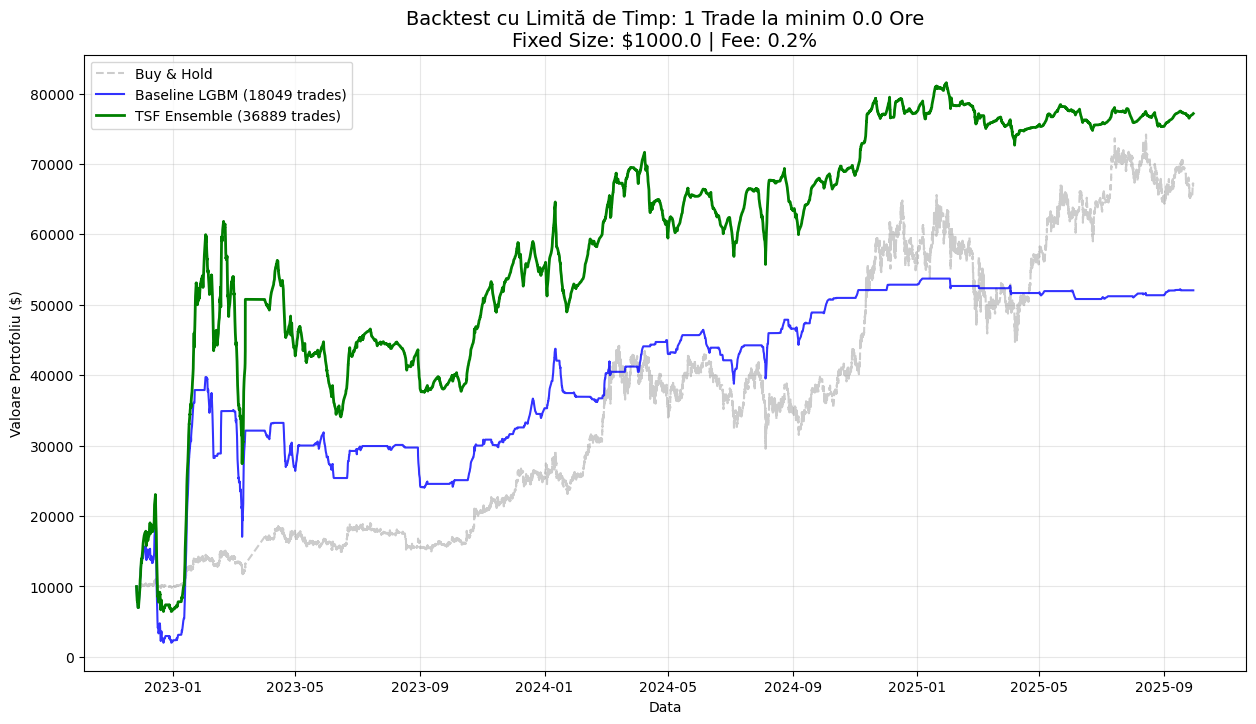


REZULTATE FINALE (Cooldown = 0.0 Ore):
------------------------------------------------------------
B&H Final:      $67,152.79
------------------------------------------------------------
BASELINE LGBM:
  Final:        $52,055.39
  Profit Net:   $42,055.39
  Tranzacții:   18049
  Taxe Plătite: $36,098.00
------------------------------------------------------------
TSF ENSEMBLE:
  Final:        $77,155.30
  Profit Net:   $67,155.30
  Tranzacții:   36889
  Taxe Plătite: $73,778.00
------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# ============================================================================
# CONFIGURARE BACKTEST CU PAUZĂ TEMPORALĂ (COOLDOWN)
# ============================================================================

INITIAL_CAPITAL = 10000.0
TRADE_SIZE = 1000.0
FEE_RATE = 0.002  # 0.2% (Binance Standard: 0.1% in + 0.1% out)
COOLDOWN_HOURS = 0.0  # <--- MODIFICĂ AICI (Câte ore aștepți minim între trade-uri)

# Ne asigurăm că indexul este datetime pentru a calcula diferența de timp
test.index = pd.to_datetime(test.index)

# Funcție pentru a rula backtest-ul cu limita de timp
def run_cooldown_backtest(df, predictions, cooldown_hours):
    equity_curve = [INITIAL_CAPITAL]
    trade_count = 0
    fees_paid = 0
    
    # Setăm timpul ultimei tranzacții mult în trecut ca să putem tranzacționa imediat la început
    last_trade_time = df.index[0] - timedelta(hours=cooldown_hours + 1)
    
    # Iterăm prin date
    # Avem nevoie de index (timp) și de predicție
    for i in range(len(df)):
        current_time = df.index[i]
        signal = predictions[i]
        ret = df['ret'].iloc[i]
        
        # LOGICA PRINCIPALĂ:
        # 1. Modelul trebuie să prezică 1
        # 2. Diferența dintre timpul curent și ultima tranzacție >= Cooldown
        time_diff = current_time - last_trade_time
        
        if signal == 1 and time_diff >= timedelta(hours=cooldown_hours):
            # --- EXECUTĂM TRADE ---
            trade_count += 1
            
            # Calcul PnL: (Investiție * Return) - (Investiție * Fee)
            # Notă: Dacă ret e negativ, pierdem bani + plătim taxa
            pnl = (TRADE_SIZE * ret) - (TRADE_SIZE * FEE_RATE)
            fee_val = TRADE_SIZE * FEE_RATE
            
            fees_paid += fee_val
            equity_curve.append(equity_curve[-1] + pnl)
            
            # Actualizăm timpul ultimei tranzacții
            last_trade_time = current_time
            
        else:
            # --- NU FACEM NIMIC (Așteptăm sau Modelul zice 0) ---
            equity_curve.append(equity_curve[-1])
            
    return equity_curve[1:], trade_count, fees_paid # Sărim peste valoarea inițială duplicată

# ============================================================================
# RULARE SIMULĂRI
# ============================================================================

# 1. Buy & Hold (Benchmark) - Simplu
price_start = test['close'].iloc[0]
bh_equity = (test['close'] / price_start) * (INITIAL_CAPITAL * (1 - 0.001)) # Fee intrare
bh_equity = bh_equity * (1 - 0.001) # Fee ieșire virtuală la final

# 2. Rulare Baseline LGBM cu Cooldown
base_equity, base_trades, base_fees = run_cooldown_backtest(test, y_pred_base, COOLDOWN_HOURS)

# 3. Rulare TSF cu Cooldown
tsf_equity, tsf_trades, tsf_fees = run_cooldown_backtest(test, y_pred_tsf, COOLDOWN_HOURS)

# ============================================================================
# VIZUALIZARE
# ============================================================================

plt.figure(figsize=(15, 8))

# Plot Buy & Hold
plt.plot(test.index, bh_equity, label='Buy & Hold', color='gray', alpha=0.4, linestyle='--')

# Plot Strategii
plt.plot(test.index, base_equity, label=f'Baseline LGBM ({base_trades} trades)', color='blue', alpha=0.8)
plt.plot(test.index, tsf_equity, label=f'TSF Ensemble ({tsf_trades} trades)', color='green', linewidth=2)

plt.title(f'Backtest cu Limită de Timp: 1 Trade la minim {COOLDOWN_HOURS} Ore\nFixed Size: ${TRADE_SIZE} | Fee: 0.2%', fontsize=14)
plt.ylabel('Valoare Portofoliu ($)')
plt.xlabel('Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ============================================================================
# RAPORT TEXT
# ============================================================================
print(f"\nREZULTATE FINALE (Cooldown = {COOLDOWN_HOURS} Ore):")
print("-" * 60)
print(f"B&H Final:      ${bh_equity.iloc[-1]:,.2f}")
print("-" * 60)
print(f"BASELINE LGBM:")
print(f"  Final:        ${base_equity[-1]:,.2f}")
print(f"  Profit Net:   ${base_equity[-1] - INITIAL_CAPITAL:,.2f}")
print(f"  Tranzacții:   {base_trades}")
print(f"  Taxe Plătite: ${base_fees:,.2f}")
print("-" * 60)
print(f"TSF ENSEMBLE:")
print(f"  Final:        ${tsf_equity[-1]:,.2f}")
print(f"  Profit Net:   ${tsf_equity[-1] - INITIAL_CAPITAL:,.2f}")
print(f"  Tranzacții:   {tsf_trades}")
print(f"  Taxe Plătite: ${tsf_fees:,.2f}")
print("-" * 60)

BACKTEST CONFIGURATION
Train events:              108068
Test events:               46316
Initial capital:           $10,000
Position size:             $1,000
Max concurrent positions:  10
Fee rate:                  0.08%

🔄 Running Baseline backtest...
🔄 Running TSF backtest...


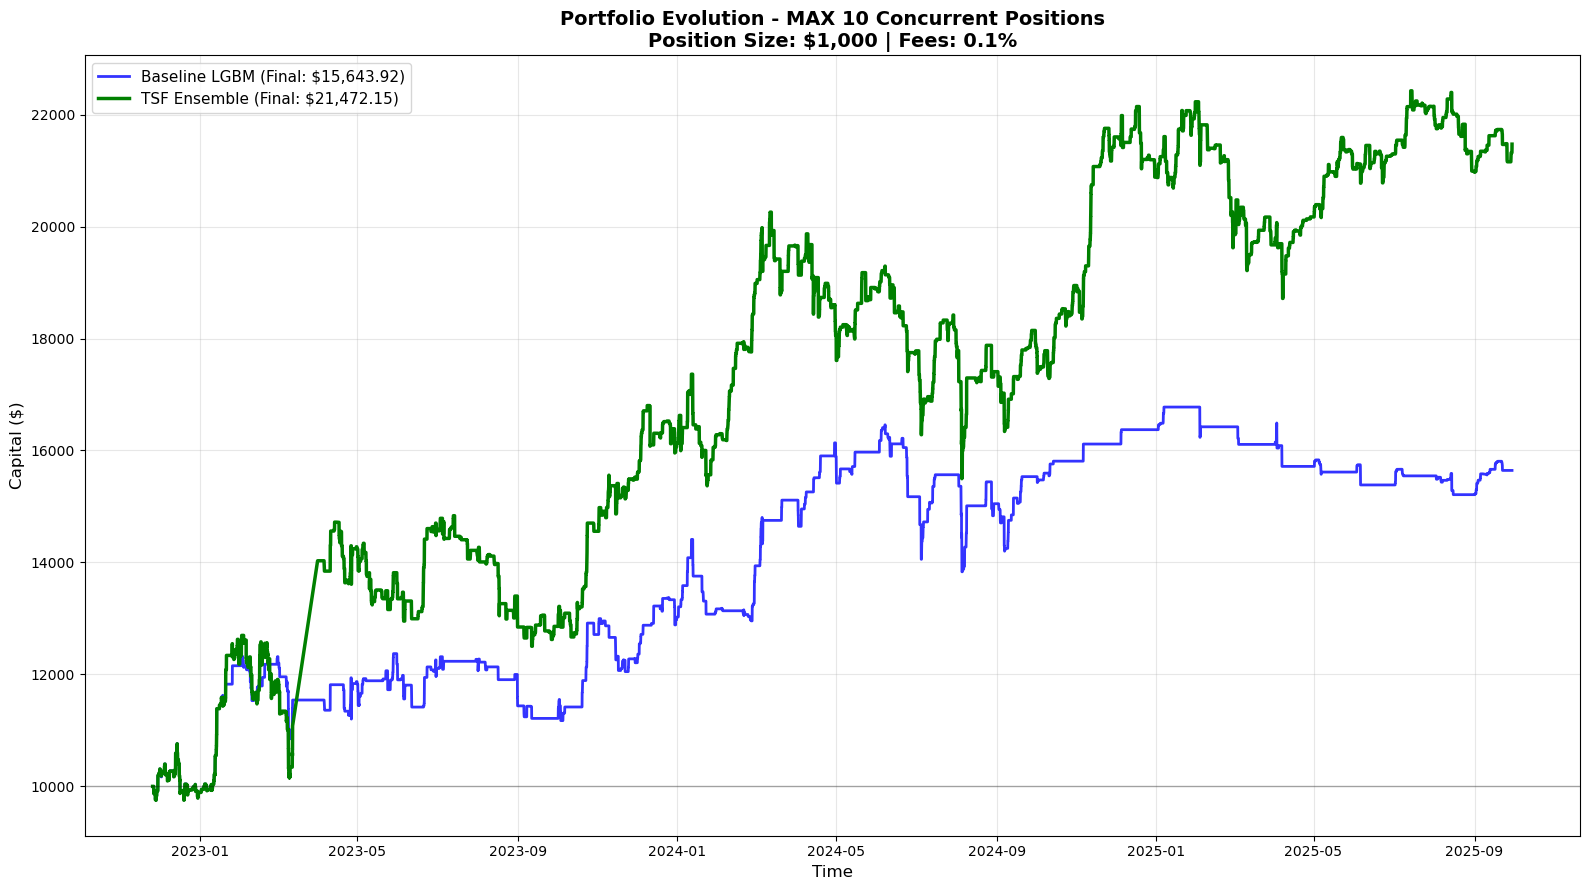


RESULTS SUMMARY (MAX 10 CONCURRENT POSITIONS)

Metric                              Baseline LGBM        TSF Ensemble        
--------------------------------------------------------------------------------
Final Capital                       $         15,643.92 $         21,472.15
Net Profit                          $          5,643.92 $         11,472.15
Return %                                         56.44%             114.72%

--------------------------------------------------------------------------------
Trades Opened                                      2536                5744
Trades Closed                                      2536                5744
Signals Rejected (at limit)                       15513               31145

--------------------------------------------------------------------------------
Total Fees Paid                     $          2,028.80 $          4,595.20
Avg Fee per Trade                   $              0.80 $              0.80

--------------------

In [570]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# ============================================================================
# CONFIGURARE BACKTEST
# ============================================================================

INITIAL_CAPITAL = 10000.0
POSITION_SIZE = 1000.0
FEE_RATE = 0.0008  # 0.2% per round-trip

# >>>>>>>>>> MODIFICĂ AICI <<<<<<<<<
MAX_CONCURRENT_POSITIONS = 10  # Câte poziții simultan vrei să ai deschise
# >>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<

class PositionTracker:
    """Trackează poziții deschise și le închide automat la exit_time"""
    
    def __init__(self, initial_capital, position_size, fee_rate, max_positions):
        self.capital = initial_capital
        self.position_size = position_size
        self.fee_rate = fee_rate
        self.max_positions = max_positions
        
        self.open_positions = []
        self.equity_curve = []
        self.timestamps = []
        
        self.total_trades_opened = 0
        self.total_trades_closed = 0
        self.total_fees = 0
        self.rejected_signals = 0
        
    def close_expired_positions(self, current_time):
        """Închide toate pozițiile care au reached exit_time <= current_time"""
        positions_to_close = []
        
        for pos in self.open_positions:
            if pos['exit_time'] <= current_time:
                positions_to_close.append(pos)
        
        total_pnl = 0
        for pos in positions_to_close:
            gross_pnl = pos['size'] * pos['realized_return']
            fee = pos['size'] * self.fee_rate
            net_pnl = gross_pnl - fee
            
            self.capital += net_pnl
            self.total_fees += fee
            self.total_trades_closed += 1
            total_pnl += net_pnl
            
            self.open_positions.remove(pos)
        
        return len(positions_to_close), total_pnl
    
    def can_open_position(self):
        """Verifică dacă putem deschide poziție nouă"""
        return (len(self.open_positions) < self.max_positions and 
                self.capital >= self.position_size)
    
    def open_position(self, entry_time, exit_time, realized_return):
        """Deschide poziție nouă"""
        if not self.can_open_position():
            self.rejected_signals += 1
            return False
        
        position = {
            'entry_time': entry_time,
            'exit_time': exit_time,
            'realized_return': realized_return,
            'size': self.position_size
        }
        
        self.open_positions.append(position)
        self.total_trades_opened += 1
        return True
    
    def record_equity(self, timestamp):
        """Record equity la acest timestamp"""
        self.timestamps.append(timestamp)
        self.equity_curve.append(self.capital)
    
    def get_stats(self):
        """Returnează statistici"""
        return {
            'final_capital': self.capital,
            'profit': self.capital - INITIAL_CAPITAL,
            'return_pct': ((self.capital / INITIAL_CAPITAL) - 1) * 100,
            'trades_opened': self.total_trades_opened,
            'trades_closed': self.total_trades_closed,
            'total_fees': self.total_fees,
            'rejected_signals': self.rejected_signals,
            'open_positions_remaining': len(self.open_positions)
        }


def run_backtest(events_df, predictions, max_positions):
    """Backtest cu limită de poziții simultan"""
    
    tracker = PositionTracker(
        initial_capital=INITIAL_CAPITAL,
        position_size=POSITION_SIZE,
        fee_rate=FEE_RATE,
        max_positions=max_positions
    )
    
    events_with_pred = events_df.copy()
    events_with_pred['prediction'] = predictions
    
    # Get toate timestamps unice (entry + exit) sorted
    all_times = sorted(set(
        events_with_pred['entry_time'].tolist() + 
        events_with_pred['exit_time'].tolist()
    ))
    
    # Iterate prin toate timestamps
    for timestamp in all_times:
        # 1. Închide poziții care au expired
        tracker.close_expired_positions(timestamp)
        
        # 2. Verifică dacă avem noi semnale la acest timestamp
        signals_at_time = events_with_pred[
            (events_with_pred['entry_time'] == timestamp) & 
            (events_with_pred['prediction'] == 1)
        ]
        
        # 3. Încearcă să deschizi poziții noi
        for idx, row in signals_at_time.iterrows():
            tracker.open_position(
                entry_time=row['entry_time'],
                exit_time=row['exit_time'],
                realized_return=row['ret']
            )
        
        # 4. Record equity
        tracker.record_equity(timestamp)
    
    return tracker


# ============================================================================
# VERIFICARE DATE
# ============================================================================

required_cols = ['entry_time', 'exit_time', 'ret', 'bin']
missing_cols = [col for col in required_cols if col not in events.columns]

if missing_cols:
    print(f"❌ ERROR: Missing columns in events DataFrame: {missing_cols}")
    print(f"Available columns: {list(events.columns)}")
    print("\n⚠️ Please run the triple barrier code first to get events with exit_time!")
else:
    # ============================================================================
    # SPLIT TRAIN/TEST
    # ============================================================================
    
    events = events.sort_index()
    split_idx = int(len(events) * 0.7)
    
    train = events.iloc[:split_idx].copy()
    test = events.iloc[split_idx:].copy()
    
    print("="*70)
    print("BACKTEST CONFIGURATION")
    print("="*70)
    print(f"Train events:              {len(train)}")
    print(f"Test events:               {len(test)}")
    print(f"Initial capital:           ${INITIAL_CAPITAL:,.0f}")
    print(f"Position size:             ${POSITION_SIZE:,.0f}")
    print(f"Max concurrent positions:  {MAX_CONCURRENT_POSITIONS}")
    print(f"Fee rate:                  {FEE_RATE*100:.2f}%")
    print("="*70)
    
    # ============================================================================
    # RUN BACKTESTS
    # ============================================================================
    
    print("\n🔄 Running Baseline backtest...")
    tracker_base = run_backtest(test, y_pred_base, MAX_CONCURRENT_POSITIONS)
    
    print("🔄 Running TSF backtest...")
    tracker_tsf = run_backtest(test, y_pred_tsf, MAX_CONCURRENT_POSITIONS)
    
    # ============================================================================
    # BUY & HOLD BENCHMARK
    # ============================================================================
    
    price_start = test['close'].iloc[0]
    bh_equity = (test['close'] / price_start) * (INITIAL_CAPITAL * (1 - 0.001))
    bh_equity = bh_equity * (1 - 0.001)
    
    # ============================================================================
    # VIZUALIZARE
    # ============================================================================
    
    plt.figure(figsize=(16, 9))
    
    # Plot Buy & Hold
    # plt.plot(test.index, bh_equity, 
    #          label=f'Buy & Hold (Final: ${bh_equity.iloc[-1]:,.2f})', 
    #          color='gray', alpha=0.5, linestyle='--', linewidth=2)
    
    # Plot Baseline
    plt.plot(tracker_base.timestamps, tracker_base.equity_curve,
             label=f'Baseline LGBM (Final: ${tracker_base.capital:,.2f})',
             color='blue', linewidth=2, alpha=0.8)
    
    # Plot TSF
    plt.plot(tracker_tsf.timestamps, tracker_tsf.equity_curve,
             label=f'TSF Ensemble (Final: ${tracker_tsf.capital:,.2f})',
             color='green', linewidth=2.5)
    
    plt.axhline(y=INITIAL_CAPITAL, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    plt.title(f'Portfolio Evolution - MAX {MAX_CONCURRENT_POSITIONS} Concurrent Positions\n'
              f'Position Size: ${POSITION_SIZE:,.0f} | Fees: {FEE_RATE*100:.1f}%',
              fontsize=14, fontweight='bold')
    
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Capital ($)', fontsize=12)
    plt.legend(loc='best', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # ============================================================================
    # STATISTICI DETALIATE
    # ============================================================================
    
    base_stats = tracker_base.get_stats()
    tsf_stats = tracker_tsf.get_stats()
    
    print("\n" + "="*80)
    print(f"RESULTS SUMMARY (MAX {MAX_CONCURRENT_POSITIONS} CONCURRENT POSITIONS)")
    print("="*80)
    
    print(f"\n{'Metric':<35} {'Baseline LGBM':<20} {'TSF Ensemble':<20}")
    print("-"*80)
    
    # Financial metrics
    print(f"{'Final Capital':<35} ${base_stats['final_capital']:>18,.2f} ${tsf_stats['final_capital']:>18,.2f}")
    print(f"{'Net Profit':<35} ${base_stats['profit']:>18,.2f} ${tsf_stats['profit']:>18,.2f}")
    print(f"{'Return %':<35} {base_stats['return_pct']:>18.2f}% {tsf_stats['return_pct']:>18.2f}%")
    
    print("\n" + "-"*80)
    
    # Trade metrics
    print(f"{'Trades Opened':<35} {base_stats['trades_opened']:>19} {tsf_stats['trades_opened']:>19}")
    print(f"{'Trades Closed':<35} {base_stats['trades_closed']:>19} {tsf_stats['trades_closed']:>19}")
    print(f"{'Signals Rejected (at limit)':<35} {base_stats['rejected_signals']:>19} {tsf_stats['rejected_signals']:>19}")
    
    print("\n" + "-"*80)
    
    # Cost metrics
    print(f"{'Total Fees Paid':<35} ${base_stats['total_fees']:>18,.2f} ${tsf_stats['total_fees']:>18,.2f}")
    print(f"{'Avg Fee per Trade':<35} ${base_stats['total_fees']/max(base_stats['trades_opened'],1):>18,.2f} ${tsf_stats['total_fees']/max(tsf_stats['trades_opened'],1):>18,.2f}")
    
    print("\n" + "-"*80)
    
    # Final state
    print(f"{'Open Positions Remaining':<35} {base_stats['open_positions_remaining']:>19} {tsf_stats['open_positions_remaining']:>19}")
    
    # Buy & Hold comparison
    bh_return = ((bh_equity.iloc[-1] / INITIAL_CAPITAL) - 1) * 100
    print("\n" + "="*80)
    print(f"Buy & Hold Return: {bh_return:.2f}%")
    print(f"Baseline vs B&H:   {base_stats['return_pct'] - bh_return:+.2f}% {'✓ Better' if base_stats['return_pct'] > bh_return else '✗ Worse'}")
    print(f"TSF vs B&H:        {tsf_stats['return_pct'] - bh_return:+.2f}% {'✓ Better' if tsf_stats['return_pct'] > bh_return else '✗ Worse'}")
    print(f"TSF vs Baseline:   {tsf_stats['return_pct'] - base_stats['return_pct']:+.2f}% {'✓ Better' if tsf_stats['return_pct'] > base_stats['return_pct'] else '✗ Worse'}")
    
    print("\n" + "="*80)
    print("✓ Backtest complete!")
    print("="*80)
    
    # ============================================================================
    # RECOMMENDATION
    # ============================================================================
    
    print("\n💡 TIP: Modifică MAX_CONCURRENT_POSITIONS la început și rulează din nou")
    print("   Teste recomandate: 1, 3, 5, 10, 20 poziții simultan")

BACKTEST CONFIGURATION
Max concurrent positions:  100
Position size:             $1,000
Fee rate:                  0.20%

🔄 Running backtests...


/var/folders/30/kw3jxm3d70d051shtg48w4500000gn/T/ipykernel_5587/1240440666.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


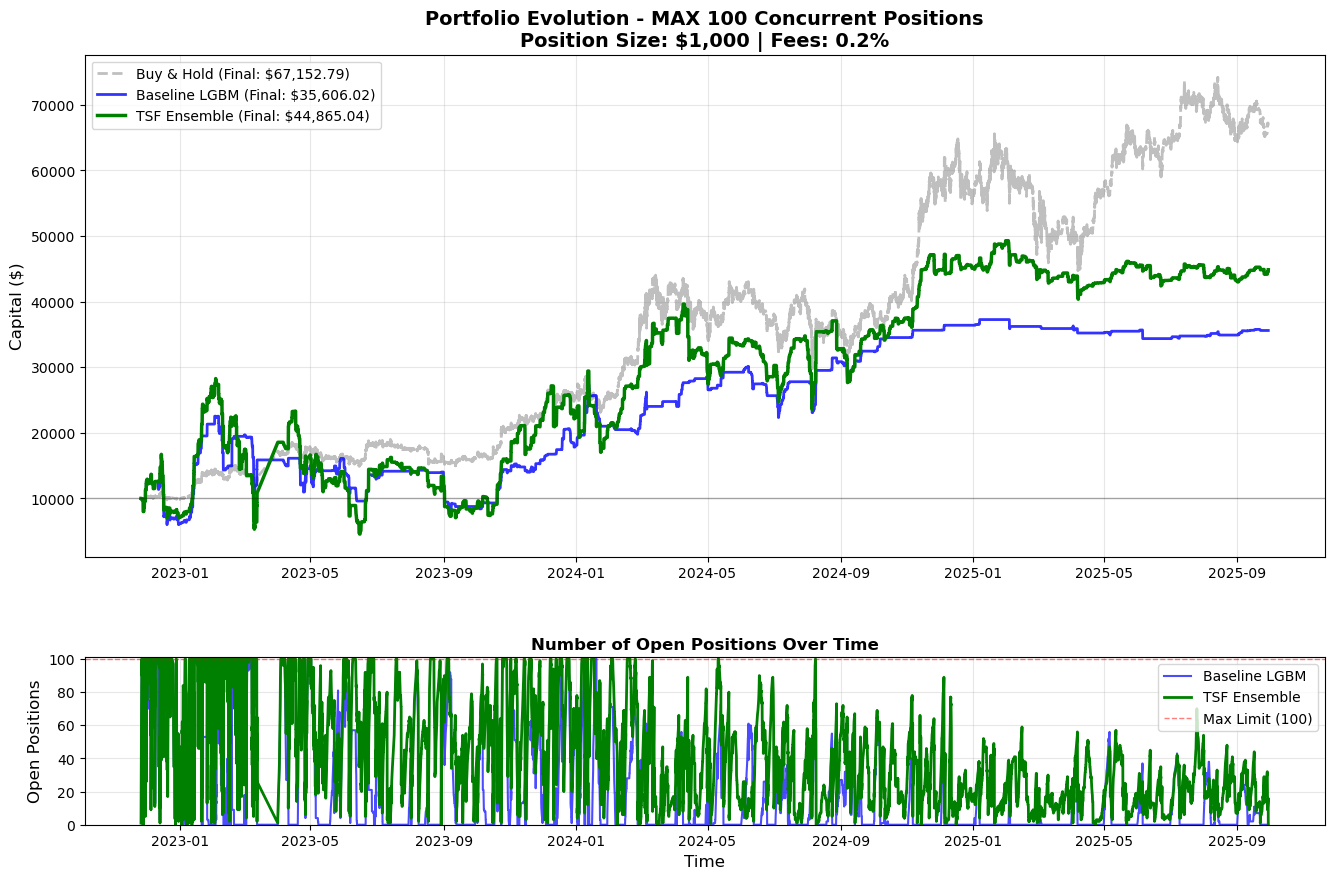


RESULTS SUMMARY (MAX 100 CONCURRENT POSITIONS)

Metric                              Baseline LGBM        TSF Ensemble        
--------------------------------------------------------------------------------
Final Capital                       $         35,606.02 $         44,865.04
Net Profit                          $         25,606.02 $         34,865.04
Return %                                        256.06%             348.65%

--------------------------------------------------------------------------------
Trades Opened                                     12267               25523
Trades Closed                                     12267               25523
Signals Rejected (at limit)                        5782               11366

--------------------------------------------------------------------------------
Max Open Positions (peak)                           100                 100
Avg Open Positions                                31.62               59.45
Open Positions Remai

In [572]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import timedelta

# ============================================================================
# CONFIGURARE BACKTEST
# ============================================================================

INITIAL_CAPITAL = 10000.0
POSITION_SIZE = 1000.0
FEE_RATE = 0.002  # 0.2% per round-trip
MAX_CONCURRENT_POSITIONS = 100  # <<<< MODIFICĂ AICI

class PositionTracker:
    """Trackează poziții deschise și le închide automat la exit_time"""
    
    def __init__(self, initial_capital, position_size, fee_rate, max_positions):
        self.capital = initial_capital
        self.position_size = position_size
        self.fee_rate = fee_rate
        self.max_positions = max_positions
        
        self.open_positions = []
        self.equity_curve = []
        self.timestamps = []
        self.open_positions_count = []  # <<<< TRACK NUMĂR POZIȚII DESCHISE
        
        self.total_trades_opened = 0
        self.total_trades_closed = 0
        self.total_fees = 0
        self.rejected_signals = 0
        
    def close_expired_positions(self, current_time):
        """Închide toate pozițiile care au reached exit_time <= current_time"""
        positions_to_close = []
        
        for pos in self.open_positions:
            if pos['exit_time'] <= current_time:
                positions_to_close.append(pos)
        
        total_pnl = 0
        for pos in positions_to_close:
            gross_pnl = pos['size'] * pos['realized_return']
            fee = pos['size'] * self.fee_rate
            net_pnl = gross_pnl - fee
            
            self.capital += net_pnl
            self.total_fees += fee
            self.total_trades_closed += 1
            total_pnl += net_pnl
            
            self.open_positions.remove(pos)
        
        return len(positions_to_close), total_pnl
    
    def can_open_position(self):
        """Verifică dacă putem deschide poziție nouă"""
        return (len(self.open_positions) < self.max_positions and 
                self.capital >= self.position_size)
    
    def open_position(self, entry_time, exit_time, realized_return):
        """Deschide poziție nouă"""
        if not self.can_open_position():
            self.rejected_signals += 1
            return False
        
        position = {
            'entry_time': entry_time,
            'exit_time': exit_time,
            'realized_return': realized_return,
            'size': self.position_size
        }
        
        self.open_positions.append(position)
        self.total_trades_opened += 1
        return True
    
    def record_equity(self, timestamp):
        """Record equity și număr poziții deschise"""
        self.timestamps.append(timestamp)
        self.equity_curve.append(self.capital)
        self.open_positions_count.append(len(self.open_positions))  # <<<< RECORD COUNT
    
    def get_stats(self):
        """Returnează statistici"""
        return {
            'final_capital': self.capital,
            'profit': self.capital - INITIAL_CAPITAL,
            'return_pct': ((self.capital / INITIAL_CAPITAL) - 1) * 100,
            'trades_opened': self.total_trades_opened,
            'trades_closed': self.total_trades_closed,
            'total_fees': self.total_fees,
            'rejected_signals': self.rejected_signals,
            'open_positions_remaining': len(self.open_positions),
            'max_open_positions': max(self.open_positions_count) if self.open_positions_count else 0,
            'avg_open_positions': np.mean(self.open_positions_count) if self.open_positions_count else 0
        }


def run_backtest(events_df, predictions, max_positions):
    """Backtest cu limită de poziții simultan"""
    
    tracker = PositionTracker(
        initial_capital=INITIAL_CAPITAL,
        position_size=POSITION_SIZE,
        fee_rate=FEE_RATE,
        max_positions=max_positions
    )
    
    events_with_pred = events_df.copy()
    events_with_pred['prediction'] = predictions
    
    # Get toate timestamps unice (entry + exit) sorted
    all_times = sorted(set(
        events_with_pred['entry_time'].tolist() + 
        events_with_pred['exit_time'].tolist()
    ))
    
    # Iterate prin toate timestamps
    for timestamp in all_times:
        # 1. Închide poziții care au expired
        tracker.close_expired_positions(timestamp)
        
        # 2. Verifică dacă avem noi semnale la acest timestamp
        signals_at_time = events_with_pred[
            (events_with_pred['entry_time'] == timestamp) & 
            (events_with_pred['prediction'] == 1)
        ]
        
        # 3. Încearcă să deschizi poziții noi
        for idx, row in signals_at_time.iterrows():
            tracker.open_position(
                entry_time=row['entry_time'],
                exit_time=row['exit_time'],
                realized_return=row['ret']
            )
        
        # 4. Record equity și count
        tracker.record_equity(timestamp)
    
    return tracker


# ============================================================================
# VERIFICARE DATE
# ============================================================================

required_cols = ['entry_time', 'exit_time', 'ret', 'bin']
missing_cols = [col for col in required_cols if col not in events.columns]

if missing_cols:
    print(f"❌ ERROR: Missing columns: {missing_cols}")
    print("Please run triple barrier code first!")
else:
    # ============================================================================
    # SPLIT TRAIN/TEST
    # ============================================================================
    
    events = events.sort_index()
    split_idx = int(len(events) * 0.7)
    
    train = events.iloc[:split_idx].copy()
    test = events.iloc[split_idx:].copy()
    
    print("="*70)
    print("BACKTEST CONFIGURATION")
    print("="*70)
    print(f"Max concurrent positions:  {MAX_CONCURRENT_POSITIONS}")
    print(f"Position size:             ${POSITION_SIZE:,.0f}")
    print(f"Fee rate:                  {FEE_RATE*100:.2f}%")
    print("="*70)
    
    # ============================================================================
    # RUN BACKTESTS
    # ============================================================================
    
    print("\n🔄 Running backtests...")
    tracker_base = run_backtest(test, y_pred_base, MAX_CONCURRENT_POSITIONS)
    tracker_tsf = run_backtest(test, y_pred_tsf, MAX_CONCURRENT_POSITIONS)
    
    # Buy & Hold
    price_start = test['close'].iloc[0]
    bh_equity = (test['close'] / price_start) * (INITIAL_CAPITAL * (1 - 0.001))
    bh_equity = bh_equity * (1 - 0.001)
    
    # ============================================================================
    # VIZUALIZARE CU 2 SUBPLOTS
    # ============================================================================
    
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.3)
    
    # ============================================================================
    # SUBPLOT 1: EQUITY CURVES
    # ============================================================================
    ax1 = fig.add_subplot(gs[0])
    
    # Plot Buy & Hold
    ax1.plot(test.index, bh_equity, 
             label=f'Buy & Hold (Final: ${bh_equity.iloc[-1]:,.2f})', 
             color='gray', alpha=0.5, linestyle='--', linewidth=2)
    
    # Plot Baseline
    ax1.plot(tracker_base.timestamps, tracker_base.equity_curve,
             label=f'Baseline LGBM (Final: ${tracker_base.capital:,.2f})',
             color='blue', linewidth=2, alpha=0.8)
    
    # Plot TSF
    ax1.plot(tracker_tsf.timestamps, tracker_tsf.equity_curve,
             label=f'TSF Ensemble (Final: ${tracker_tsf.capital:,.2f})',
             color='green', linewidth=2.5)
    
    ax1.axhline(y=INITIAL_CAPITAL, color='black', linestyle='-', alpha=0.3, linewidth=1)
    
    ax1.set_title(f'Portfolio Evolution - MAX {MAX_CONCURRENT_POSITIONS} Concurrent Positions\n'
                  f'Position Size: ${POSITION_SIZE:,.0f} | Fees: {FEE_RATE*100:.1f}%',
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('Capital ($)', fontsize=12)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # ============================================================================
    # SUBPLOT 2: NUMĂR POZIȚII DESCHISE
    # ============================================================================
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    
    # Plot număr poziții deschise pentru fiecare strategie
    ax2.plot(tracker_base.timestamps, tracker_base.open_positions_count,
             label='Baseline LGBM', color='blue', linewidth=1.5, alpha=0.7)
    
    ax2.plot(tracker_tsf.timestamps, tracker_tsf.open_positions_count,
             label='TSF Ensemble', color='green', linewidth=2)
    
    # Adaugă linie pentru limita maximă
    ax2.axhline(y=MAX_CONCURRENT_POSITIONS, 
                color='red', linestyle='--', linewidth=1, alpha=0.5,
                label=f'Max Limit ({MAX_CONCURRENT_POSITIONS})')
    
    ax2.set_title('Number of Open Positions Over Time', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Open Positions', fontsize=12)
    ax2.set_ylim(0, MAX_CONCURRENT_POSITIONS + 1)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ============================================================================
    # STATISTICI DETALIATE
    # ============================================================================
    
    base_stats = tracker_base.get_stats()
    tsf_stats = tracker_tsf.get_stats()
    
    print("\n" + "="*80)
    print(f"RESULTS SUMMARY (MAX {MAX_CONCURRENT_POSITIONS} CONCURRENT POSITIONS)")
    print("="*80)
    
    print(f"\n{'Metric':<35} {'Baseline LGBM':<20} {'TSF Ensemble':<20}")
    print("-"*80)
    
    # Financial metrics
    print(f"{'Final Capital':<35} ${base_stats['final_capital']:>18,.2f} ${tsf_stats['final_capital']:>18,.2f}")
    print(f"{'Net Profit':<35} ${base_stats['profit']:>18,.2f} ${tsf_stats['profit']:>18,.2f}")
    print(f"{'Return %':<35} {base_stats['return_pct']:>18.2f}% {tsf_stats['return_pct']:>18.2f}%")
    
    print("\n" + "-"*80)
    
    # Trade metrics
    print(f"{'Trades Opened':<35} {base_stats['trades_opened']:>19} {tsf_stats['trades_opened']:>19}")
    print(f"{'Trades Closed':<35} {base_stats['trades_closed']:>19} {tsf_stats['trades_closed']:>19}")
    print(f"{'Signals Rejected (at limit)':<35} {base_stats['rejected_signals']:>19} {tsf_stats['rejected_signals']:>19}")
    
    print("\n" + "-"*80)
    
    # Position metrics
    print(f"{'Max Open Positions (peak)':<35} {base_stats['max_open_positions']:>19} {tsf_stats['max_open_positions']:>19}")
    print(f"{'Avg Open Positions':<35} {base_stats['avg_open_positions']:>19.2f} {tsf_stats['avg_open_positions']:>19.2f}")
    print(f"{'Open Positions Remaining':<35} {base_stats['open_positions_remaining']:>19} {tsf_stats['open_positions_remaining']:>19}")
    
    print("\n" + "-"*80)
    
    # Cost metrics
    print(f"{'Total Fees Paid':<35} ${base_stats['total_fees']:>18,.2f} ${tsf_stats['total_fees']:>18,.2f}")
    
    # Buy & Hold comparison
    bh_return = ((bh_equity.iloc[-1] / INITIAL_CAPITAL) - 1) * 100
    print("\n" + "="*80)
    print(f"Buy & Hold Return: {bh_return:.2f}%")
    print(f"Baseline vs B&H:   {base_stats['return_pct'] - bh_return:+.2f}% {'✓ Better' if base_stats['return_pct'] > bh_return else '✗ Worse'}")
    print(f"TSF vs B&H:        {tsf_stats['return_pct'] - bh_return:+.2f}% {'✓ Better' if tsf_stats['return_pct'] > bh_return else '✗ Worse'}")
    print(f"TSF vs Baseline:   {tsf_stats['return_pct'] - base_stats['return_pct']:+.2f}% {'✓ Better' if tsf_stats['return_pct'] > base_stats['return_pct'] else '✗ Worse'}")
    
    print("\n" + "="*80)
    print("✓ Backtest complete!")
    print("="*80)